# 패키지 설치

In [1]:
!pip install torch torchvision numpy matplotlib tensorboard thop

# 데이터셋 준비(CIFAR-10)

In [2]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# CIFAR-10 데이터 전처리 및 로드 (이미지 크기 유지)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# CIFAR-10 데이터셋 로드
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


100%|██████████| 170M/170M [00:03<00:00, 48.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


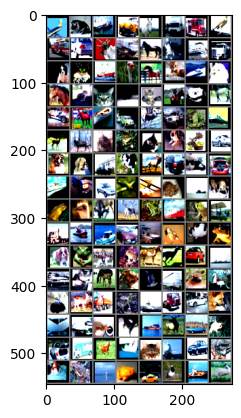

plane cat   ship  car   horse truck truck bird 


In [3]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋에서 클래스 이름 정의 (CIFAR-10 클래스 이름)
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 데이터셋에서 이미지를 추출하고 시각화
def imshow(img):
    img = img / 2 + 0.5  # 정규화 해제
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 샘플 배치 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

# 레이블 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))


In [14]:
import torch
import torch.nn as nn

class LightweightVGG16(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Adaptive Average Pooling
            nn.AdaptiveAvgPool2d((1, 1)),  # Always outputs (256, 1, 1)
        )

        # Classifier Block
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),  # 256 is the number of channels after AdaptiveAvgPool2d
            nn.ReLU(inplace=True),
            nn.Linear(512, 10),  # For CIFAR-10 classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [8]:
!pip install pytorch-model-summary
from pytorch_model_summary import summary

model = LightweightVGG16()
print(summary(model, torch.zeros((128, 3, 32, 32)), show_input=True, show_hierarchical=True))

model = model.to(device)

------------------------------------------------------------------------------
           Layer (type)           Input Shape         Param #     Tr. Param #
               Conv2d-1      [128, 3, 32, 32]             896             896
          BatchNorm2d-2     [128, 32, 32, 32]              64              64
                 ReLU-3     [128, 32, 32, 32]               0               0
               Conv2d-4     [128, 32, 32, 32]           9,248           9,248
          BatchNorm2d-5     [128, 32, 32, 32]              64              64
                 ReLU-6     [128, 32, 32, 32]               0               0
            MaxPool2d-7     [128, 32, 32, 32]               0               0
               Conv2d-8     [128, 32, 16, 16]          18,496          18,496
          BatchNorm2d-9     [128, 64, 16, 16]             128             128
                ReLU-10     [128, 64, 16, 16]               0               0
              Conv2d-11     [128, 64, 16, 16]          36,928  

In [9]:
!pip install ptflops

# 모델 설정 및 기본 학습

In [16]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchvision.models import VGG16_BN_Weights
import torch.optim as optim

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightweightVGG16()
model = model.to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [17]:
# 초기 성능 평가
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, total_correct = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_correct / len(loader.dataset)
    return avg_loss, avg_acc

# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 초기 성능 평가
initial_loss, initial_acc = evaluate(model, test_loader, criterion, device)
print(f"초기 성능: Loss = {initial_loss:.4f}, Accuracy = {initial_acc * 100:.2f}%")

초기 성능: Loss = 2.3031, Accuracy = 10.00%


In [18]:
import os

# 모델 저장 경로
save_dir = "./saved_models"
os.makedirs(save_dir, exist_ok=True)
model_save_path = os.path.join(save_dir, "lightweight_vgg16.pth")

# 학습 코드
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct = 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()

    avg_loss = total_loss / len(loader.dataset)
    avg_acc = total_correct / len(loader.dataset)
    return avg_loss, avg_acc

# 학습 및 평가 루프
epochs = 40
train_losses, train_accs = [], []
val_losses, val_accs = [], []

best_val_acc = 0.0  # 최적의 성능 저장용 변수

for epoch in range(1, epochs + 1):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch}/{epochs}]: "
          f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc * 100:.2f}%, "
          f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc * 100:.2f}%")

    # 모델 저장 (최적의 Validation Accuracy를 기준으로)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_acc": val_acc,
        }, model_save_path)
        print(f"Model saved at epoch {epoch} with Val Acc = {val_acc * 100:.2f}%")

print(f"Training complete. Best Val Acc = {best_val_acc * 100:.2f}%")


Epoch [1/40]: Train Loss = 1.4293, Train Acc = 47.34%, Val Loss = 1.2596, Val Acc = 56.44%
Model saved at epoch 1 with Val Acc = 56.44%
Epoch [2/40]: Train Loss = 0.9482, Train Acc = 66.58%, Val Loss = 0.8931, Val Acc = 69.07%
Model saved at epoch 2 with Val Acc = 69.07%
Epoch [3/40]: Train Loss = 0.7570, Train Acc = 73.76%, Val Loss = 0.6823, Val Acc = 76.63%
Model saved at epoch 3 with Val Acc = 76.63%
Epoch [4/40]: Train Loss = 0.6506, Train Acc = 77.41%, Val Loss = 0.6957, Val Acc = 76.20%
Epoch [5/40]: Train Loss = 0.5795, Train Acc = 79.91%, Val Loss = 0.6233, Val Acc = 78.84%
Model saved at epoch 5 with Val Acc = 78.84%
Epoch [6/40]: Train Loss = 0.5378, Train Acc = 81.45%, Val Loss = 0.5511, Val Acc = 81.11%
Model saved at epoch 6 with Val Acc = 81.11%
Epoch [7/40]: Train Loss = 0.4932, Train Acc = 82.96%, Val Loss = 0.6758, Val Acc = 78.21%
Epoch [8/40]: Train Loss = 0.4624, Train Acc = 84.13%, Val Loss = 0.5378, Val Acc = 82.26%
Model saved at epoch 8 with Val Acc = 82.26%
Ep

In [21]:
from ptflops import get_model_complexity_info

# 1. 프루닝된 모델 불러오기
# 프루닝된 모델 정의
model = LightweightVGG16()

# 저장된 프루닝된 모델에서 가중치만 로드
pruned_model_path = "/content/saved_models/lightweight_vgg16.pth"
checkpoint = torch.load(pruned_model_path)
model.load_state_dict(checkpoint["model_state_dict"])  # 가중치만 로드

# 2. FLOPs와 파라미터 수 계산
with torch.cuda.device(0):  # GPU 사용 (CUDA)
    macs, params = get_model_complexity_info(model, (3, 32, 32), as_strings=True, verbose=True)

# 결과 출력
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")

LightweightVGG16(
  3.82 M, 100.000% Params, 79.49 MMac, 99.747% MACs, 
  (features): Sequential(
    3.68 M, 96.422% Params, 79.36 MMac, 99.575% MACs, 
    (0): Conv2d(896, 0.023% Params, 917.5 KMac, 1.151% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, 0.002% Params, 65.54 KMac, 0.082% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 32.77 KMac, 0.041% MACs, inplace=True)
    (3): Conv2d(9.25 k, 0.242% Params, 9.47 MMac, 11.883% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, 0.002% Params, 65.54 KMac, 0.082% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(0, 0.000% Params, 32.77 KMac, 0.041% MACs, inplace=True)
    (6): MaxPool2d(0, 0.000% Params, 32.77 KMac, 0.041% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(18.5 k, 0.484% Params, 4.73 MMac, 5.941% MACs, 32, 64,

<ipython-input-21-2e4543ac8be6>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pruned_model_path)


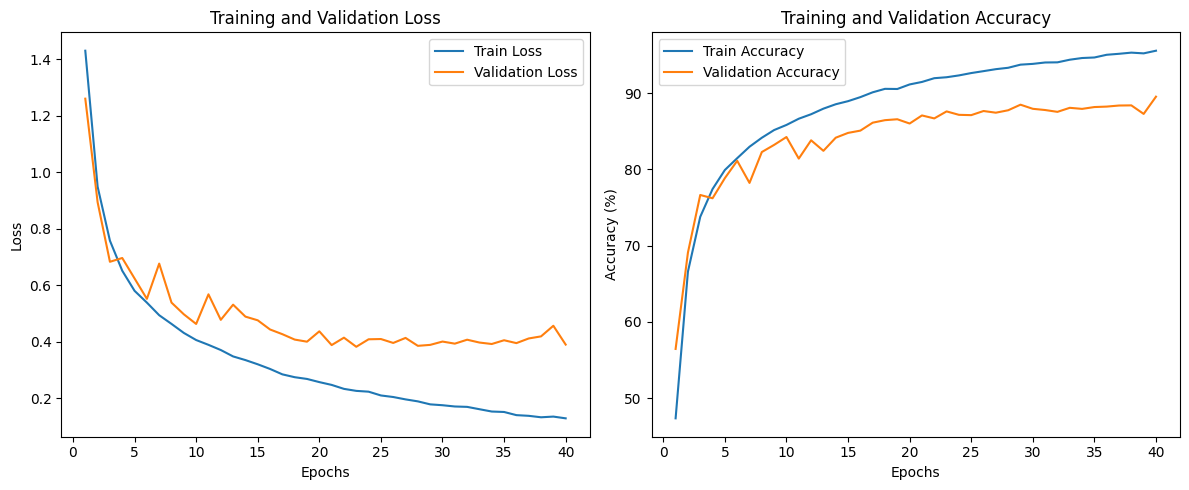

In [22]:
import matplotlib.pyplot as plt

# 학습 곡선 시각화
plt.figure(figsize=(12, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), [acc * 100 for acc in train_accs], label='Train Accuracy')
plt.plot(range(1, epochs + 1), [acc * 100 for acc in val_accs], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# 필터 중요도 계산 및 프루닝

In [168]:
def get_pruned_network(model, layer_idx, num_prune_channels):
    """
    주어진 모델의 특정 Conv2D 레이어를 L1-norm 기반으로 가지치기합니다.

    Args:
        model (nn.Module): PyTorch 모델.
        layer_idx (int): Conv2D 레이어의 인덱스 (Conv2D 기준).
        num_prune_channels (int): 가지치기할 필터(채널) 수.

    Returns:
        model (nn.Module): 가지치기 후 업데이트된 모델.
    """
    # 모델의 Conv2D 및 BatchNorm 레이어를 추출
    conv_bn_pairs = []
    for idx, layer in enumerate(model.features):
        if isinstance(layer, nn.Conv2d):
            bn_layer = None
            if idx + 1 < len(model.features) and isinstance(model.features[idx + 1], nn.BatchNorm2d):
                bn_layer = model.features[idx + 1]
            conv_bn_pairs.append((layer, bn_layer))

    # Conv2D 계층 인덱스 확인
    if layer_idx >= len(conv_bn_pairs):
        raise ValueError(f"layer_idx({layer_idx})가 Conv2D 계층 수({len(conv_bn_pairs)})를 초과합니다.")

    conv_layer, bn_layer = conv_bn_pairs[layer_idx]

    if num_prune_channels >= conv_layer.out_channels:
        raise ValueError(f"Prune channels ({num_prune_channels}) cannot exceed or equal the total channels ({conv_layer.out_channels}).")

    # L1-norm 기반 필터 중요도 계산
    weight = conv_layer.weight
    l1_norms = torch.sum(torch.abs(weight), dim=(1, 2, 3))
    saving_indices = torch.topk(l1_norms, k=l1_norms.size(0) - num_prune_channels, largest=True).indices

    # 가지치기된 가중치 및 편향 계산
    pruned_weight = weight[saving_indices]
    pruned_bias = conv_layer.bias[saving_indices] if conv_layer.bias is not None else None

    # Conv2D 계층 새로 생성
    new_conv_layer = torch.nn.Conv2d(
        in_channels=conv_layer.in_channels,
        out_channels=len(saving_indices),
        kernel_size=conv_layer.kernel_size,
        stride=conv_layer.stride,
        padding=conv_layer.padding,
        dilation=conv_layer.dilation,
        groups=conv_layer.groups,
        bias=conv_layer.bias is not None,
    )
    new_conv_layer.weight.data = pruned_weight
    if conv_layer.bias is not None:
        new_conv_layer.bias.data = pruned_bias

    # BatchNorm 교체
    if bn_layer:
        pruned_bn_weight = bn_layer.weight[saving_indices]
        pruned_bn_bias = bn_layer.bias[saving_indices]
        pruned_bn_running_mean = bn_layer.running_mean[saving_indices]
        pruned_bn_running_var = bn_layer.running_var[saving_indices]
        new_bn_layer = torch.nn.BatchNorm2d(len(saving_indices))
        new_bn_layer.weight.data = pruned_bn_weight
        new_bn_layer.bias.data = pruned_bn_bias
        new_bn_layer.running_mean.data = pruned_bn_running_mean
        new_bn_layer.running_var.data = pruned_bn_running_var

    # Sequential 객체 업데이트
    features = list(model.features)
    features[features.index(conv_layer)] = new_conv_layer
    if bn_layer:
        features[features.index(bn_layer)] = new_bn_layer

    # 다음 Conv2D의 입력 채널 수정
    if layer_idx + 1 < len(conv_bn_pairs):  # 다음 Conv2D가 존재하는 경우
        next_conv_layer = conv_bn_pairs[layer_idx + 1][0]

        # 새로운 Conv2D 계층 정의
        new_next_conv_layer = torch.nn.Conv2d(
            in_channels=len(saving_indices),
            out_channels=next_conv_layer.out_channels,
            kernel_size=next_conv_layer.kernel_size,
            stride=next_conv_layer.stride,
            padding=next_conv_layer.padding,
            dilation=next_conv_layer.dilation,
            groups=next_conv_layer.groups,
            bias=next_conv_layer.bias is not None,
        )

        # 다음 Conv2D의 가중치 업데이트
        new_next_conv_layer.weight.data = next_conv_layer.weight.data[:, saving_indices, :, :]
        if next_conv_layer.bias is not None:
            new_next_conv_layer.bias.data = next_conv_layer.bias.data

        # 업데이트된 Conv2D 계층을 features에 반영
        features[features.index(next_conv_layer)] = new_next_conv_layer

    else:  # 다음 Conv2D 계층이 없는 경우, FC 계층 수정
        print(f"No next Conv2D layer to modify for layer {layer_idx}.")

        # 마지막 Conv2D 이후 FC 계층 수정
        classifier = list(model.classifier)
        fc_in_features = len(saving_indices)  # 프루닝된 Conv2D의 출력 채널
        new_fc_layer = torch.nn.Linear(
            in_features=fc_in_features,
            out_features=classifier[1].out_features,
            bias=True
        )

        # 기존 가중치를 프루닝된 채널에 맞게 복사
        new_fc_layer.weight.data = classifier[1].weight.data[:, :fc_in_features]
        if classifier[1].bias is not None:
            new_fc_layer.bias.data = classifier[1].bias.data

        # FC 계층 업데이트
        classifier[1] = new_fc_layer
        model.classifier = torch.nn.Sequential(*classifier)

    # 업데이트된 features 리스트를 nn.Sequential로 변환
    model.features = nn.Sequential(*features)

    print(f"Layer {layer_idx} pruned: {weight.shape[0]} → {len(saving_indices)}")
    return model



In [169]:
# 모델 정의
model = LightweightVGG16()

# Pruning 설정
layer_idx = 0  # Pruning할 Conv2D 레이어의 Conv2D 인덱스
num_prune_channels = 5  # 제거할 필터 수

# Pruning 수행
pruned_model = get_pruned_network(model, layer_idx, num_prune_channels)

# 결과 확인
print(pruned_model)


Layer 0 pruned: 32 → 27
LightweightVGG16(
  (features): Sequential(
    (0): Conv2d(3, 27, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(27, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=

In [170]:
def testAccuracy(_new_pruned_model, _val_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """
    모델 Top-1 및 Top-5 정확도 계산 함수.

    Args:
        _new_pruned_model (torch.nn.Module): 평가할 프루닝된 모델.
        _val_loader (DataLoader): 검증 데이터 로더.
        device (torch.device): 평가에 사용할 디바이스 (기본값: CUDA 가능 시 GPU).

    Returns:
        tuple: (Top-1 정확도, Top-5 정확도)
    """
    top1_correct = 0
    top1_total = 0
    top5_correct = 0

    _new_pruned_model.eval()
    with torch.no_grad():
        for data in _val_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = _new_pruned_model(images)

            # Top-1 정확도
            _, predicted = torch.max(outputs, 1)
            top1_correct += (predicted == labels).sum().item()
            top1_total += labels.size(0)

            # Top-5 정확도
            top5_correct += torch.sum(labels.view(-1, 1) == torch.topk(outputs, 5, dim=1).indices).item()

    # 정확도 계산
    top1_acc = 100 * top1_correct / top1_total if top1_total > 0 else 0.0
    top5_acc = 100 * top5_correct / top1_total if top1_total > 0 else 0.0

    print(f"Top-1 Accuracy: {top1_acc:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc:.2f}%")

    return top1_acc, top5_acc


In [171]:
import torch
import pickle
import copy
from torch.utils.data import DataLoader

# Conv 레이어 별로 10% ~ 95% 필터 가지치기 수행
filters_pruned_away_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95]  # 프루닝 비율 (%)

# 데이터 로더 및 디바이스
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 로드
model = LightweightVGG16()
checkpoint = torch.load('/content/saved_models/lightweight_vgg16.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

# 정확도 결과 저장
top1_acc_list = {}
top5_acc_list = {}

# Conv 레이어 추출
conv_layers = [i for i, layer in enumerate(model.features) if isinstance(layer, torch.nn.Conv2d)]

# 각 Conv2D 레이어에 대해 프루닝 수행
for conv_layer_index, conv_layer_idx in enumerate(conv_layers):
    top1_acc_list[conv_layer_index] = []
    top5_acc_list[conv_layer_index] = []

    print(f"\n{'='*20} Layer {conv_layer_index+1} {'='*20}")

    for pruned_rate in filters_pruned_away_list:
        print(f"\nPruning Rate: {pruned_rate}%")

        # 모델 복사
        model_copy = copy.deepcopy(model)

        # Conv2D 레이어 접근
        layer = model_copy.features[conv_layer_idx]

        # 프루닝할 필터 수 계산
        num_prune_channels = int(layer.weight.data.shape[0] * pruned_rate / 100)

        # 프루닝 수행
        pruned_model = get_pruned_network(model_copy, conv_layer_index, num_prune_channels)
        print(f"Pruned {num_prune_channels} filters from Layer {conv_layer_index+1}.")

        # 정확도 평가
        top1_acc, top5_acc = testAccuracy(pruned_model, test_loader, device)
        top1_acc_list[conv_layer_index].append(top1_acc)
        top5_acc_list[conv_layer_index].append(top5_acc)

        print(f"Top-1 Accuracy: {top1_acc:.2f}%, Top-5 Accuracy: {top5_acc:.2f}%")


# 정확도 결과 저장
with open('/content/Figure/top1_acc_list.pkl', 'wb') as f:
    pickle.dump(top1_acc_list, f)
with open('/content/Figuretop5_acc_list.pkl', 'wb') as f:
    pickle.dump(top5_acc_list, f)

print("\nPruning and evaluation completed!")


<ipython-input-171-096d8c2e963b>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/saved_models/lightweight_vgg16.pth')



==================== Layer 1 ====================

Pruning Rate: 10%
Layer 0 pruned: 32 → 29
Pruned 3 filters from Layer 1.
Top-1 Accuracy: 77.91%
Top-5 Accuracy: 98.12%
Top-1 Accuracy: 77.91%, Top-5 Accuracy: 98.12%

Pruning Rate: 20%
Layer 0 pruned: 32 → 26
Pruned 6 filters from Layer 1.
Top-1 Accuracy: 77.65%
Top-5 Accuracy: 98.06%
Top-1 Accuracy: 77.65%, Top-5 Accuracy: 98.06%

Pruning Rate: 30%
Layer 0 pruned: 32 → 23
Pruned 9 filters from Layer 1.
Top-1 Accuracy: 77.79%
Top-5 Accuracy: 98.27%
Top-1 Accuracy: 77.79%, Top-5 Accuracy: 98.27%

Pruning Rate: 40%
Layer 0 pruned: 32 → 20
Pruned 12 filters from Layer 1.
Top-1 Accuracy: 67.60%
Top-5 Accuracy: 95.12%
Top-1 Accuracy: 67.60%, Top-5 Accuracy: 95.12%

Pruning Rate: 50%
Layer 0 pruned: 32 → 16
Pruned 16 filters from Layer 1.
Top-1 Accuracy: 57.55%
Top-5 Accuracy: 92.71%
Top-1 Accuracy: 57.55%, Top-5 Accuracy: 92.71%

Pruning Rate: 60%
Layer 0 pruned: 32 → 13
Pruned 19 filters from Layer 1.
Top-1 Accuracy: 37.12%
Top-5 Accuracy

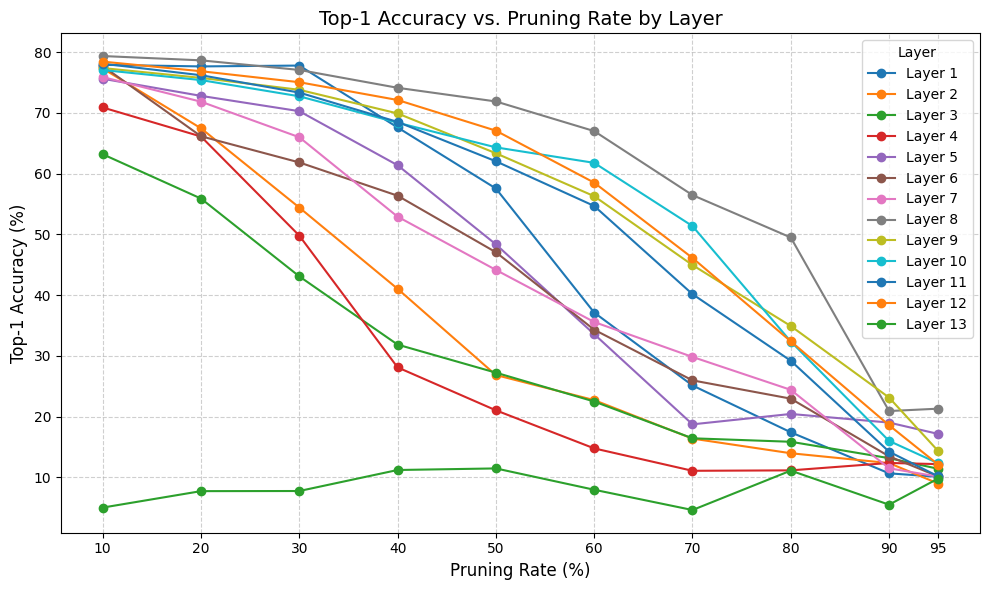

In [173]:
# 필요한 모듈 임포트
import pickle
import matplotlib.pyplot as plt

# Top-1 Accuracy 데이터 불러오기
with open('/content/Figure/top1_acc_list.pkl', 'rb') as f:
    top1_acc_list = pickle.load(f)

# 프루닝 비율 리스트 (시각화에 필요)
filters_pruned_away_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95]

# 시각화
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
for layer_idx, acc in top1_acc_list.items():
    assert len(filters_pruned_away_list) == len(acc), f"Layer {layer_idx+1}: Length mismatch!"
    plt.plot(filters_pruned_away_list, acc, marker='o', label=f"Layer {layer_idx+1}")

# 그래프 설정
plt.title("Top-1 Accuracy vs. Pruning Rate by Layer", fontsize=14)
plt.xlabel("Pruning Rate (%)", fontsize=12)
plt.ylabel("Top-1 Accuracy (%)", fontsize=12)
plt.xticks(filters_pruned_away_list)  # x축 값 고정
plt.legend(title="Layer", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)  # 그리드 추가
plt.tight_layout()  # 레이아웃 정리
plt.show()


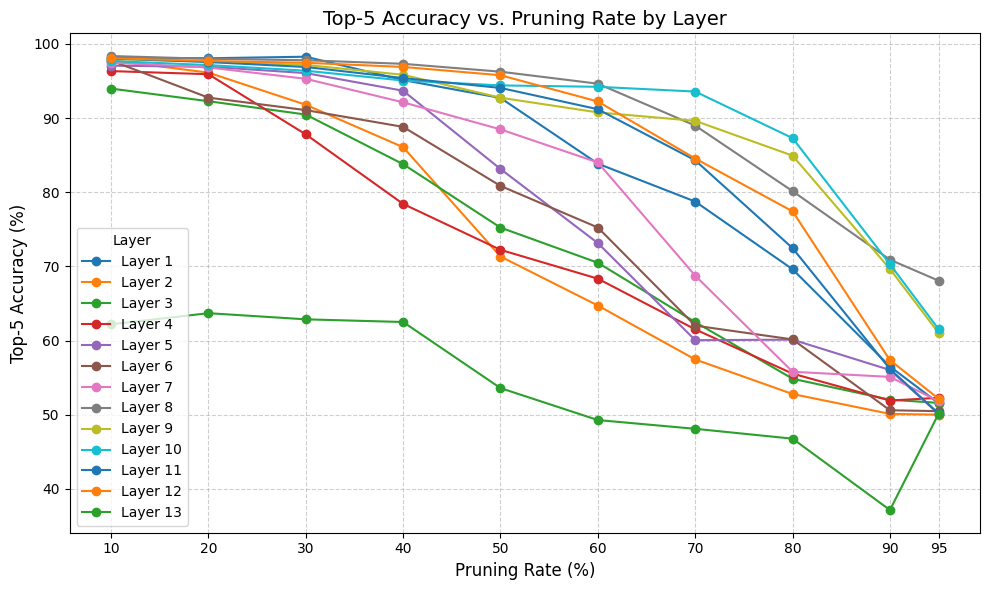

In [174]:
# 필요한 모듈 임포트
import pickle
import matplotlib.pyplot as plt

# Top-5 Accuracy 데이터 불러오기
with open('/content/Figure/top5_acc_list.pkl', 'rb') as f:
    top5_acc_list = pickle.load(f)

# 프루닝 비율 리스트 (시각화에 필요)
filters_pruned_away_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95]

# 시각화
plt.figure(figsize=(10, 6))  # 그래프 크기 설정
for layer_idx, acc in top5_acc_list.items():
    assert len(filters_pruned_away_list) == len(acc), f"Layer {layer_idx+1}: Length mismatch!"
    plt.plot(filters_pruned_away_list, acc, marker='o', label=f"Layer {layer_idx+1}")

# 그래프 설정
plt.title("Top-5 Accuracy vs. Pruning Rate by Layer", fontsize=14)
plt.xlabel("Pruning Rate (%)", fontsize=12)
plt.ylabel("Top-5 Accuracy (%)", fontsize=12)
plt.xticks(filters_pruned_away_list)  # x축 값 고정
plt.legend(title="Layer", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)  # 그리드 추가
plt.tight_layout()  # 레이아웃 정리
plt.show()


In [175]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

pruned_params = count_parameters(pruned_model)
print(f"Number of parameters after pruning: {pruned_params}")

Number of parameters after pruning: 3136081


In [176]:
from ptflops import get_model_complexity_info

# 모델 입력 크기 정의 (CIFAR-10의 경우 3x32x32)
input_size = (3, 32, 32)

# FLOPs 및 파라미터 계산
macs, params = get_model_complexity_info(pruned_model, input_size, as_strings=True, print_per_layer_stat=True)
print(f"FLOPs: {macs}")
print(f"Parameters: {params}")


LightweightVGG16(
  3.14 M, 100.000% Params, 77.13 MMac, 99.742% MACs, 
  (features): Sequential(
    3.12 M, 99.608% Params, 77.11 MMac, 99.726% MACs, 
    (0): Conv2d(896, 0.029% Params, 917.5 KMac, 1.187% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, 0.002% Params, 65.54 KMac, 0.085% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 32.77 KMac, 0.042% MACs, inplace=True)
    (3): Conv2d(9.25 k, 0.295% Params, 9.47 MMac, 12.247% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, 0.002% Params, 65.54 KMac, 0.085% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(0, 0.000% Params, 32.77 KMac, 0.042% MACs, inplace=True)
    (6): MaxPool2d(0, 0.000% Params, 32.77 KMac, 0.042% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(18.5 k, 0.590% Params, 4.73 MMac, 6.123% MACs, 32, 64,

In [177]:
# 원본 모델
original_params = count_parameters(model)
original_macs, original_flops = get_model_complexity_info(model, input_size, as_strings=True)

# 프루닝된 모델
pruned_params = count_parameters(pruned_model)
pruned_macs, pruned_flops = get_model_complexity_info(pruned_model, input_size, as_strings=True)

# 비교 출력
print(f"Original Parameters: {original_params}, FLOPs: {original_flops}")
print(f"Pruned Parameters: {pruned_params}, FLOPs: {pruned_flops}")


LightweightVGG16(
  3.82 M, 100.000% Params, 79.49 MMac, 99.747% MACs, 
  (features): Sequential(
    3.68 M, 96.422% Params, 79.36 MMac, 99.575% MACs, 
    (0): Conv2d(896, 0.023% Params, 917.5 KMac, 1.151% MACs, 3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, 0.002% Params, 65.54 KMac, 0.082% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 32.77 KMac, 0.041% MACs, inplace=True)
    (3): Conv2d(9.25 k, 0.242% Params, 9.47 MMac, 11.883% MACs, 32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, 0.002% Params, 65.54 KMac, 0.082% MACs, 32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(0, 0.000% Params, 32.77 KMac, 0.041% MACs, inplace=True)
    (6): MaxPool2d(0, 0.000% Params, 32.77 KMac, 0.041% MACs, kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(18.5 k, 0.484% Params, 4.73 MMac, 5.941% MACs, 32, 64,

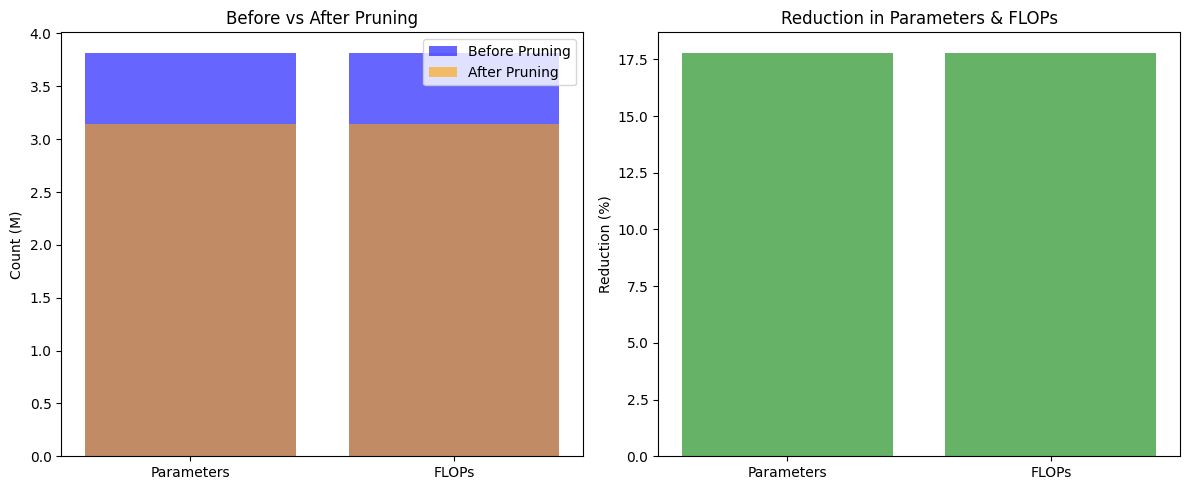

In [178]:
import matplotlib.pyplot as plt

# 데이터 준비
original_params = 3.82  # 원본 모델 파라미터 수 (M)
pruned_params = 3.14  # 프루닝 후 파라미터 수 (M)
original_flops = 3.82  # 원본 모델 FLOPs (M)
pruned_flops = 3.14  # 프루닝 후 FLOPs (M)

# 파라미터 감소율
param_reduction = (original_params - pruned_params) / original_params * 100
flops_reduction = (original_flops - pruned_flops) / original_flops * 100

# 시각화
labels = ['Parameters', 'FLOPs']
before = [original_params, original_flops]
after = [pruned_params, pruned_flops]
reduction = [param_reduction, flops_reduction]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Before & After 비교
ax[0].bar(labels, before, color='blue', alpha=0.6, label='Before Pruning')
ax[0].bar(labels, after, color='orange', alpha=0.6, label='After Pruning')
ax[0].set_ylabel('Count (M)')
ax[0].set_title('Before vs After Pruning')
ax[0].legend()

# 감소율
ax[1].bar(labels, reduction, color='green', alpha=0.6)
ax[1].set_ylabel('Reduction (%)')
ax[1].set_title('Reduction in Parameters & FLOPs')

plt.tight_layout()
plt.show()


In [180]:
# 모델 로드
model = LightweightVGG16()
checkpoint = torch.load('/content/saved_models/lightweight_vgg16.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

# 모델 성능 평가
print("\nEvaluating the pruned model...")
top1_acc, top5_acc = testAccuracy(model, test_loader, device)

print(f"Model Top-1 Accuracy: {top1_acc:.2f}%")
print(f"Model Top-5 Accuracy: {top5_acc:.2f}%")


<ipython-input-180-e0b6bdd51d01>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/saved_models/lightweight_vgg16.pth')



Evaluating the pruned model...
Top-1 Accuracy: 79.15%
Top-5 Accuracy: 98.31%
Model Top-1 Accuracy: 79.15%
Model Top-5 Accuracy: 98.31%


# 재학습 및 성능 평가

In [183]:
import torch.optim as optim

def retrain_pruned_model(pruned_model, train_loader, test_loader, epochs=20, lr=0.001):
    """
    프루닝된 모델을 재학습(retraining)합니다.

    Args:
        pruned_model (torch.nn.Module): 프루닝된 모델
        train_loader (DataLoader): 학습 데이터 로더
        test_loader (DataLoader): 검증 데이터 로더
        epochs (int): 재학습 epoch 수 (기본값: 20)
        lr (float): 학습률 (기본값: 0.001)

    Returns:
        trained_model (torch.nn.Module): 재학습된 모델
    """
    # 손실 함수와 옵티마이저 정의
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.Adam(pruned_model.parameters(), lr=lr)

    pruned_model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward 및 Loss 계산
            optimizer.zero_grad()
            outputs = pruned_model(inputs)
            loss = criterion(outputs, labels)

            # Backward 및 가중치 업데이트
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

        # 중간 성능 확인
        if (epoch + 1) % 5 == 0:  # 5 epoch마다 성능 평가
            print("\n[Validation Performance]")
            testAccuracy(pruned_model, test_loader, device)

    return pruned_model


In [184]:
# Retraining
trained_pruned_model = retrain_pruned_model(pruned_model, train_loader, test_loader, epochs=40, lr=0.001)

# Retraining 후 성능 확인
print("\n[Performance After Retraining]")
top1_acc, top5_acc = testAccuracy(trained_pruned_model, test_loader, device)
print(f"Top-1 Accuracy After Retraining: {top1_acc:.2f}%")
print(f"Top-5 Accuracy After Retraining: {top5_acc:.2f}%")


Epoch [1/20], Loss: 0.3272
Epoch [2/20], Loss: 0.2985
Epoch [3/20], Loss: 0.2709
Epoch [4/20], Loss: 0.2581
Epoch [5/20], Loss: 0.2410

[Validation Performance]
Top-1 Accuracy: 74.48%
Top-5 Accuracy: 96.33%
Epoch [6/20], Loss: 0.3335
Epoch [7/20], Loss: 0.2679
Epoch [8/20], Loss: 0.2542
Epoch [9/20], Loss: 0.2352
Epoch [10/20], Loss: 0.2148

[Validation Performance]
Top-1 Accuracy: 76.70%
Top-5 Accuracy: 96.76%
Epoch [11/20], Loss: 0.2083
Epoch [12/20], Loss: 0.2097
Epoch [13/20], Loss: 0.2056
Epoch [14/20], Loss: 0.1982
Epoch [15/20], Loss: 0.1854

[Validation Performance]
Top-1 Accuracy: 79.99%
Top-5 Accuracy: 97.99%
Epoch [16/20], Loss: 0.1839
Epoch [17/20], Loss: 0.1773
Epoch [18/20], Loss: 0.1749
Epoch [19/20], Loss: 0.1686
Epoch [20/20], Loss: 0.1681

[Validation Performance]
Top-1 Accuracy: 77.72%
Top-5 Accuracy: 97.10%

[Performance After Retraining]
Top-1 Accuracy: 77.72%
Top-5 Accuracy: 97.10%
Top-1 Accuracy After Retraining: 77.72%
Top-5 Accuracy After Retraining: 97.10%


# 결과 시각화 및 분석


In [ ]:
# 프루닝된 모델 저장
torch.save(model.state_dict(), "pruned_model.pth")
